In [2]:
import tensorflow as tf   ### models
import numpy as np ### math computations
import matplotlib.pyplot as plt ### plots
import sklearn ### machine learning library
import cv2 as cv ## image processing
import joblib ## load and import model
import os
import seaborn as sns ### visualizations
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Resizing, Rescaling,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.keras import layers, regularizers
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
train_dir = "images/seg_train"
val_dir = "images/seg_test"

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.3)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3)

In [5]:
train_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    class_mode='categorical',
    batch_size=32,
    subset='training',
    shuffle=True)

val_set = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150,150),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True)

Found 9822 images belonging to 6 classes.
Found 2102 images belonging to 6 classes.


In [26]:
model = tf.keras.Sequential([
    Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    Dropout(rate= 0.3),

    Conv2D(64,(3,3),activation='relu'),
    MaxPool2D(pool_size=(2,2)),

    Flatten(),

    Dense(128,activation='relu',kernel_regularizer=regularizers.l2(0.01)),
    Dense(32,activation='relu'),
    Dense(6,activation='softmax')
])

In [27]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 148, 148, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 82944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │      10,616,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,640,806 (40.59 MB)

 Trainable params: 10,640,742 (40.59 MB)

 Non-trainable params: 64 (256.00 B)

In [28]:
model.compile('adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [29]:
es_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    mode='auto',
    restore_best_weights=True)

lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    verbose=0,
    mode='auto')

In [30]:
%%time 
history = model.fit(train_set,
                    steps_per_epoch=train_set.samples//32,
                    epochs=10,
                    validation_data=val_set,
                    validation_steps=val_set.samples//32,
                    callbacks = [es_callback,lr_callback])

Epoch 1/10


C:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


306/306 ━━━━━━━━━━━━━━━━━━━━ 592s 2s/step - accuracy: 0.4550 - loss: 5.9138 - val_accuracy: 0.5952 - val_loss: 2.0782 - learning_rate: 0.0010
Epoch 2/10
  1/306 ━━━━━━━━━━━━━━━━━━━━ 4:27 878ms/step - accuracy: 0.7500 - loss: 1.3064

C:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7500 - loss: 1.3064 - val_accuracy: 0.5000 - val_loss: 2.0632 - learning_rate: 0.0010
Epoch 3/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 324s 1s/step - accuracy: 0.6725 - loss: 1.2884 - val_accuracy: 0.6226 - val_loss: 1.3474 - learning_rate: 0.0010
Epoch 4/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 787us/step - accuracy: 0.8125 - loss: 1.0373 - val_accuracy: 0.5909 - val_loss: 1.3262 - learning_rate: 0.0010
Epoch 5/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 322s 1s/step - accuracy: 0.7126 - loss: 1.0673 - val_accuracy: 0.7197 - val_loss: 1.0619 - learning_rate: 0.0010
Epoch 6/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 803us/step - accuracy: 0.7188 - loss: 0.9999 - val_accuracy: 0.7727 - val_loss: 0.9876 - learning_rate: 0.0010
Epoch 7/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 322s 1s/step - accuracy: 0.7342 - loss: 1.0219 - val_accuracy: 0.7644 - val_loss: 0.9405 - learning_rate: 0.0010
Epoch 8/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 688us/step - accuracy: 0.7500 - loss: 1.0611 - va

In [31]:
val_loss, val_accuracy = model.evaluate(val_set)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

66/66 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - accuracy: 0.7405 - loss: 0.9762
Validation Loss: 0.9649381041526794
Validation Accuracy: 0.7473834156990051


In [8]:
val_loss, val_accuracy = model.evaluate(val_set)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

C:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


66/66 ━━━━━━━━━━━━━━━━━━━━ 62s 930ms/step - accuracy: 0.7635 - loss: 0.9305
Validation Loss: 0.9649381637573242
Validation Accuracy: 0.7473834156990051


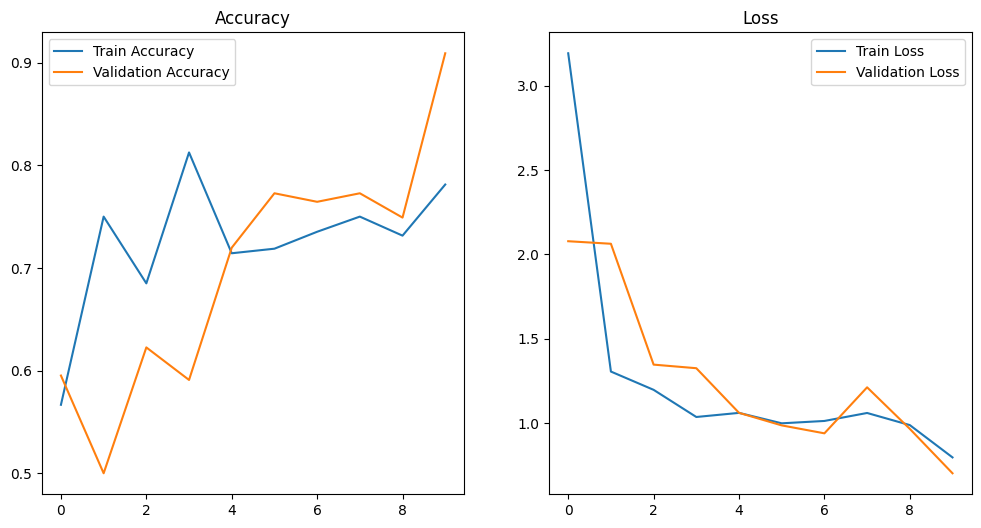

In [32]:
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.show()

In [33]:
print("class indices : ",train_set.class_indices)

class indices :  {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [3]:
from tensorflow.keras.preprocessing import image

def predict_img(img_path):
    img = image.load_img(img_path,target_size = (150,150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array,axis = 0)
    img_array /= 255.0

    pred = model.predict(img_array)
    class_idx = np.argmax(pred[0])
    class_labels =  {0: 'buildings',1: 'forest',2: 'glacier',3: 'mountain',4: 'sea',5: 'street'}

    plt.imshow(img)
    plt.title(f'Predicted: {class_labels[class_idx]}')
    plt.show()

    print(f'Predicted class: {class_labels[class_idx]} with probability: {pred[0][class_idx]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step


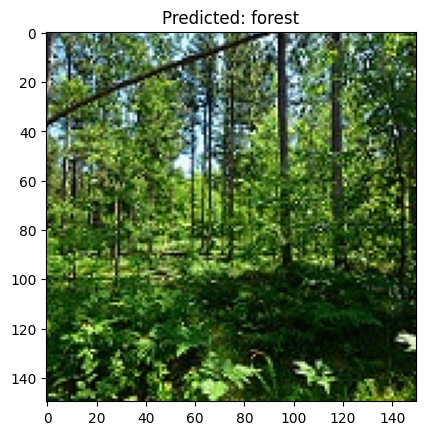

Predicted class: forest with probability: 0.9988223910331726


In [38]:
predict_img("images/seg_pred/64.jpg")

In [55]:
import joblib

joblib.dump(model,'intel_image_classification_model.pkl')

['intel_image_classification_model.pkl']

In [6]:
import joblib

model = joblib.load('intel_image_classification_model.pkl')

In [7]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 148, 148, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 82944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │      10,616,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,922,292 (121.77 MB)

 Trainable params: 10,640,742 (40.59 MB)

 Non-trainable params: 64 (256.00 B)

 Optimizer params: 21,281,486 (81.18 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


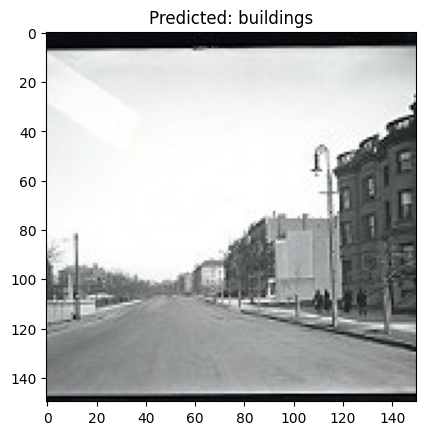

Predicted class: buildings with probability: 0.4752797782421112


In [26]:
predict_img("images/seg_pred/169.jpg")